# Implementing Model Soups

In this assignment, we will guide you through the motivation behind [Model Soups](https://arxiv.org/abs/2203.05482) and explain why it usually outperforms other methods. We will start out fine-tuning a single ResNet model, move on to Ensemble Learning, and then introduce the Model Soups technique. 


## Setup
We recommend working on Colab with GPU enabled since this assignment needs a fair amount of compute.
In Colab, we can enforce using GPU by clicking `Runtime -> Change Runtime Type -> Hardware accelerator` and selecting `GPU`.
The dependencies will be installed once the notebooks are excuted.

You should make a copy of this notebook to your Google Drive otherwise the outputs will not be saved.
Once the folder is copied, you can start working by clicking a Jupyter Notebook and openning it in Colab.

In [19]:
!pip install jax-resnet
!pip install flatten-dict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Mount Google Drive to notebook
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/cs182_final

Mounted at /content/drive/
/content/drive/.shortcut-targets-by-id/1sukHccN68Nh8Ll76UD_M9g2ElGhyGzty/cs182_final


In [3]:
# Imports
from flax import linen as nn
import numpy as np
import matplotlib.pyplot as plt

import jax
import optax
import flax
import jax.numpy as jnp
from jax import jit
from jax import lax
from jax_resnet import pretrained_resnet, slice_variables, Sequential
from flax.jax_utils import replicate, unreplicate
from flax.training import train_state, checkpoints
from flax import linen as nn, traverse_util
from flax.core import FrozenDict,frozen_dict
from flax.training.common_utils import shard
from functools import partial
from flax.core.frozen_dict import freeze

from tqdm.notebook import tqdm

from utils import get_model_and_variables, load_datasets
from utils import Config
from utils import create_train_state, zero_grads, create_mask, accuracy
from utils import train_step, val_step, test_step
from utils import train, get_optimizer

## PART A: Fine tune a single RESNET Model

For our model, we will be using the ResNet18 model architecture as the backbone and then creating a 2-layer Head that will be used in our fine-tuning. Here is a diagram of the model below:

PUT DIAGRAM HERE (Arya)

In [4]:
class Head(nn.Module):
    '''head model'''
    batch_norm_cls: partial = partial(nn.BatchNorm, momentum=0.9)
    def __call__(self, inputs, train: bool):
        output_n = inputs.shape[-1]
        x = self.batch_norm_cls(use_running_average=not train)(inputs)
        x = nn.Dropout(rate=0.25)(x, deterministic=not train)
        x = nn.Dense(features=output_n)(x)
        x = nn.relu(x)
        x = self.batch_norm_cls(use_running_average=not train)(x)
        x = nn.Dropout(rate=0.5)(x, deterministic=not train)
        x = nn.Dense(features=Config["NUM_LABELS"])(x)
        return x


class Model(nn.Module):
    '''Combines backbone and head model'''
    backbone: Sequential
    head: Head
        
    def __call__(self, inputs, train: bool):
        x = self.backbone(inputs)
        x = jnp.mean(x, axis=(1, 2)) # average pool layer
        x = self.head(x, train)
        return x

Question 1: When we fine-tune why do we cut off the last 2 layers?

Answer: YOUR ANSWER HERE

Question 2: What do the first n-2 layers of the model do?

Answer: YOUR ANSWER HERE

Question 3: Why do we use a different datasets with fine-tuning and pretraining?

Answer: YOUR ANSWER HERE

In [5]:
# Load the pre-trained model
model, variables = get_model_and_variables()

# Define the loss and evaluation functions
loss_fn = optax.softmax_cross_entropy
eval_fn = accuracy

Downloading: "https://github.com/pytorch/vision/zipball/v0.6.0" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [6]:
# Load in the training an test dataset
train_dataset, test_dataset = load_datasets()

In [7]:
# Define the different hyperparamter options (verified in paper)
learning_rates = [1e-4, 3e-5, 2e-5, 3e-6]
weight_decays = [1e-2, 1e-3, 2e-3, 1e-4]
optimizers = ['rmsprop', 'adam', 'adamw']

In [8]:
# Fine tunes a single model by randomly choosing hyperparameters
def fine_tune_model(model, testing=False, save_path='single_model'):
    accs = {}

    # Randomly choose the hyperparameters
    lr_index = np.random.choice(range(len(learning_rates)))       # STUDENT IMPLEMENTATION
    lr = learning_rates[lr_index]                 
    
    weight_index = np.random.choice(range(len(weight_decays)))    # STUDENT IMPLEMENTATION
    weight_decay = weight_decays[weight_index]
    
    epochs = np.random.choice(range(10,21))                       # STUDENT IMPLEMENTATION
    if testing: epochs = 1

    optimizer_type = np.random.choice(range(3))                   # STUDENT IMPLEMENTATION
    optimizer = get_optimizer(optimizer_type, lr, weight_decay)

    optimizer = optax.multi_transform(
        {'optim': optimizer, 'zero': zero_grads()},
        create_mask(variables['params'], lambda s: s.startswith('backbone'))
    )

    # Create the TrainState
    state = create_train_state(model, variables, optimizer, loss_fn, accuracy)

    # Required for parallelism
    state = replicate(state)

    # Display the model hyperparams
    print("Model Hyperparams")
    print(f"Epochs: {epochs}, Optimizer: {optimizers[optimizer_type]}, LR: {lr}, Weight Decay: {weight_decay}")
    
    # Train the last two layers of the model
    train_acc, valid_acc = train(state, epochs, train_dataset, test_dataset, save_path)    

    return state

In [9]:
# Helper function to flatten pretrained weights
def flatten_weights(params):
  for k, v in params.items():
    if isinstance(v, dict):
      flatten_weights(v)
    else:
      params[k] = v[0]

# Get logits and validation accuracies given a model state
def evaluate_model(state):
    all_logits = np.zeros((1, 10))
    val_accuracies = []

    iter_n = len(test_dataset)
    with tqdm(total=iter_n, desc=f"{iter_n} iterations", leave=False) as progress_bar:
      for _batch in test_dataset:
          batch = _batch[0]
          labels = _batch[1]

          batch = jnp.array(batch, dtype=jnp.float32)
          labels = jnp.array(labels, dtype=jnp.float32)

          variables = {
              'params': state.params, 
              'batch_stats': state.batch_stats
          }

          ### BEGIN CODE HERE ###
          # Forward pass through the model
          logits = state.apply_fn(variables, batch, train=False)                     
         
          # Compare the model output to ground-truth labels
          acc = state.eval_fn(logits, labels)[0]             

          ### END CODE HERE ###
          
          all_logits = np.concatenate((all_logits, np.array(logits)))
          val_accuracies.append(acc)

          progress_bar.update(1)
          
          del(batch)
          del(labels)


    # Compute the avg validation accuracy across batches
    avg_valid_acc = sum(val_accuracies)/len(val_accuracies)

    # Reshape to (num_data_points, 10)
    all_logits = np.array(all_logits)

    return all_logits[1:], avg_valid_acc

In [10]:
# Fine tunes our single RESNET model
print("Fine Tuning Model")

# The validation accuracy should be 75% or higher!!
fine_tuned_model_state = fine_tune_model(model, testing=True) # Remove for final submission

Fine Tuning Model
Model Hyperparams
Epochs: 1, Optimizer: adamw, LR: 3e-05, Weight Decay: 0.01
0


1563 iterations:   0%|          | 0/1563 [00:00<?, ?it/s]

[1/1] Train Loss: 1.74 | Train Accuracy: 0.423


313 iterations:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/jax/interpreters/mlir.py:622: UserWarning: Some donated buffers were not usable: ShapedArray(int32[], weak_type=True), ShapedArray(float32[64]), ShapedArray(float32[64]), ShapedArray(float32[7,7,3,64]), ShapedArray(float32[64]), ShapedArray(float32[64]), ShapedArray(float32[3,3,64,64]), ShapedArray(float32[64]), ShapedArray(float32[64]), ShapedArray(float32[3,3,64,64]), ShapedArray(float32[64]), ShapedArray(float32[64]), ShapedArray(float32[3,3,64,64]), ShapedArray(float32[64]), ShapedArray(float32[64]), ShapedArray(float32[3,3,64,64]), ShapedArray(float32[128]), ShapedArray(float32[128]), ShapedArray(float32[3,3,64,128]), ShapedArray(float32[128]), ShapedArray(float32[128]), ShapedArray(float32[3,3,128,128]), ShapedArray(float32[128]), ShapedArray(float32[128]), ShapedArray(float32[1,1,64,128]), ShapedArray(float32[128]), ShapedArray(float32[128]), ShapedArray(float32[3,3,128,128]), ShapedArray(float32[128]), ShapedArray(float32[128]), ShapedArra

[1/10] Valid Accuracy: 0.702


## PART B: Fine tuning multiple RESNET models

Now that we have had practice fine tuning a single RESNET model, let us repeat the same process for multiple models. Due to long training times, we have pretrained k models ahead of time (each trained with a random set of valid hyperparameters). Your job will be to collect the validation accuracies of these k models and compare them.

Question: Why do we vary the hyperparameters across the k models?

Answer: YOUR ANSWER HERE

In [11]:
# Load in the pretrained weights for k different models
def load_pretrained_models(k=8):
  dummy_optim = optax.adam(learning_rate=1e-3, b1=0.9, b2=0.999, eps=1e-6)
  loss_fn = optax.softmax_cross_entropy
  eval_fn = accuracy

  states = []
  for i in range(k):
      model, variables = get_model_and_variables()
      state_dict = checkpoints.restore_checkpoint(f'./models182/model_{i}/checkpoint_15', target=None)
      state = create_train_state(model, state_dict, dummy_optim, loss_fn, eval_fn)
      flatten_weights(state.params)
      states.append(state)

      print(f"Model {i} Loaded")
  
  print("All models loaded sucessfully :)")
  return states

In [12]:
# Get all the state accuracies 
def evaluate_models(states):
    val_accs = []
    all_logits = []
    for i, state in enumerate(states):
        print(f"Model {i}")
        ### BEGIN CODE HERE ###    
        logits, acc = evaluate_model(state)
        all_logits.append(logits)
        val_accs.append(acc)
        ### END CODE HERE ##

    return all_logits, val_accs

In [13]:
# Load in model states
states = load_pretrained_models(k=8)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Model 0 Loaded


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Model 1 Loaded


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Model 2 Loaded


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Model 3 Loaded


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Model 4 Loaded


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Model 5 Loaded


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Model 6 Loaded


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Model 7 Loaded
All models loaded sucessfully :)


In [ ]:
# Evaluate the models
all_logits, val_accs = evaluate_models(states)

Model 0


313 iterations:   0%|          | 0/313 [00:00<?, ?it/s]

Exception ignored in: <function tqdm.__del__ at 0x7f3d33bd18b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tqdm/std.py", line 1161, in __del__
    def __del__(self):
KeyboardInterrupt: 


KeyboardInterrupt: ignored

In [14]:
# Pass in new head parameters and get a state used for evaluating performance
def create_eval_state(head_params):
    _, variables = get_model_and_variables()
    variables = variables.unfreeze()
    variables['params']['head'] = head_params
    variables = frozen_dict.freeze(variables)
    state = create_train_state(model, variables, optax.adam(0), loss_fn, eval_fn)
    return state

In [ ]:
# Graph all the model accuracies (label the best one)
names = [f'Model {i+1}' for i in range(len(states))]

plt.bar(names, np.array(val_accs))
plt.title("Validation Accuracy By Model")
plt.ylim([0.7, 0.9])
plt.xticks(rotation=30, ha='right')

NameError: ignored

In [ ]:
best_individual_model = max(val_accs)

## Ensemble Learning: Average the logits of the models

In [ ]:
def majority_vote(logits):
  preds = []
  votes = np.argmax(np.array(logits), axis=2).T
  most_freq = []
  for n in votes:
      counts = np.bincount(n) 
      most_freq.append(np.argwhere(counts == np.max(counts))[-1][0])
  return most_freq

def softmax(logits, val_accs):
  denom = sum(val_accs)
  avg_logits = np.zeros(logits.shape)
  for i in range(len(val_accs)):
    avg_logits += val_accs[i]/denom * logits[i]
  return avg_logits

In [ ]:
import sklearn

# get ensemble learning accruacy 
def get_ensemble_acc(states):
    acc = None
    all_labels = []
    for _batch in test_dataset:
        labels = _batch[1]
        labels = jnp.array(labels, dtype=jnp.float32)
        all_labels.extend(labels)
    
    ### BEGIN CODE HERE ###
    
    # avg_logits = np.average(all_logits, axis=0)

    # preds = majority_vote(all_logits)
    # acc = sklearn.metrics.accuracy_score(all_labels, preds)

    avg_logits = softmax(np.array(all_logits), val_accs)
    acc = eval_fn(avg_logits, np.array(all_labels))[0]
    
    ### END CODE HERE ###
    return np.array(acc)

In [ ]:
# Graph the validation accuracy of ensemble model vs individual models
ensemble_acc = get_ensemble_acc(states)
print(f'Ensemble Learning Validation Accuracy: {ensemble_acc}')

In [ ]:
# Add the ensemble model accuracy
new_accs = val_accs + [ensemble_acc]

# Graph all the model accuracies (including emnsemble)
names = [f'Model {i+1}' for i in range(len(states))] + ['Ensemble']
plt.bar(names, new_accs, color=['blue'] * len(states) + ['green'])
plt.title("Validation Accuracy ")
plt.ylim([0.7, 0.9])
plt.xticks(rotation=30, ha='right')

Question: What are the advantages and disadvantages of ensemble learning?

Answer: YOUR ANSWER HERE

## Uniform Soup

Below are some of the different types of soups that you will be implementing.Instead of weighting the output logits as done in ensemble learning, we average the weights of the models themselves! This produces one final model, a “soup” of the individual ones.

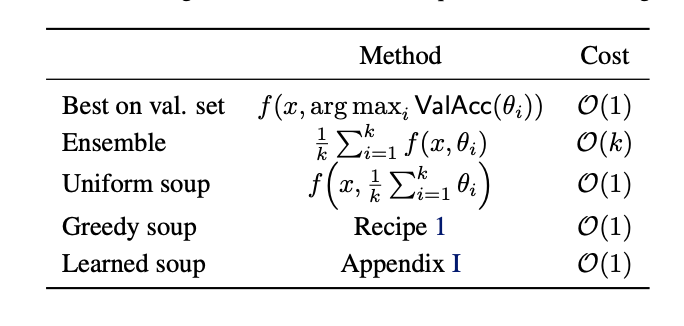

In [36]:
from flatten_dict import flatten, unflatten

def get_uniform_soup(states):
  soup_head = states[0].params['head'].copy()
  flat_soup_head = flatten(soup_head)

  for state in states:
    head = state.params['head']
    flat_head = flatten(head)

    for key, param in flat_head.items():
      print(flat_soup_head[key].flags)
      flat_soup_head[key] += param
    
  num_models = len(states)
  for key, param in flat_soup_head.items():
    flat_soup_head[key] = param / num_models
  
  soup_head = unflatten(flat_soup_head)
  soup_state = create_eval_state(soup_head)

  return soup_state

In [37]:
# THIS IS ERRORING RIGHT NOW
soup_state = get_uniform_soup(states)
_, uniform_soup_acc = evaluate_model(soup_state)

print(f'Soup Validation Acc: {uniform_soup_acc}')

AttributeError: ignored

In [ ]:
# Add the ensemble model accuracy
new_accs = val_accs + [uniform_soup_acc]

# Graph all the model accuracies (including emnsemble)
names = names + ['Uniform Soup']
plt.bar(names, new_accs, color=['blue'] * (len(names) - 1) + ['green'])
plt.title("Validation Accuracy ")
plt.ylim([0.7, 0.9])
plt.xticks(rotation=30, ha='right')

Question: What is one major benefit of using a model soup over ensemble learning? HINT: Think in terms of time complexity.

Answer: Only requires one forward pass as opposed to k passes (one for each model).

## Greedy Soup Implementation

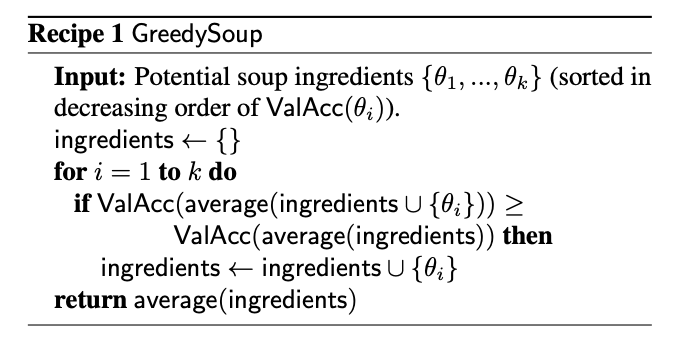

Question: Why does greedy soup perform better than uniform? Do you think this is always the case?

Answer: 

Question: What are the benefits of souping vs traditional ensemble methods in terms of space and time complexity?

Answer: 

## Learned Soup Implementation

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a527420b-c11f-44a4-82a9-68959d523a68' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>